<h1 style="text-align: center;" markdown="1">Machine Learning Algorithms for Poverty Prediction</h1> 
<h2 style="text-align: center;" markdown="2">A project of the World Bank's Knowledge for Change Program</h2>
<h3 style="text-align: center;" markdown="3">(KCP, Grant TF0A4534)</h3>


> *This notebook is part of a series that has been developed as an empirical comparative assessment of machine learning classification algorithms applied to poverty prediction. The objectives of this project are to explore how well machine learning algorithms perform when given the task to identify the poor in a given population, and to provide a resource of machine learning techniques for researchers, data scientists, and statisticians in developing countries.*

<h1 style="text-align: center;" markdown="3">Algorithm 4 - Bernoulli Naive Bayes Classifier</h1> 
<h2 style="text-align: center;" markdown="3">Part 1: Malawi Poverty Prediction</h2> 

# Table of Contents
[Introduction](#introduction)  
&nbsp;&nbsp;&nbsp;[Explanation and Theory](#introduction-theory)  
&nbsp;&nbsp;&nbsp;[Considerations](#introduction-considerations)  
[Data Setup](#setup)  
[Scikit-Learn Bernoulli Naive Bayes](#sklearn-nb)  
&nbsp;&nbsp;&nbsp;[Include All Features](#all-feats)  
&nbsp;&nbsp;&nbsp;[Tune Parameters and Cross-Validate](#tune-cv)  
[Classifier Calibration](#calibration) 
[Feature Selection](#feature-selection)  
[Summary](#summary)

# Naive Bayes Classifier Introduction <a class="anchor" id="introduction"></a>
Naive Bayes classifiers are a family of generative probabilistic clasiifiers that are fast, easy to implement, and therefore often used as a first-pass model for classification tasks. The _naivety_ in the name is due to the assumption that the features of the data are conditionally independent of one another given the class label. This idependence assumption leads to a closed-form maximum likilihood estimation, model complexity that is linear in the number of features, and the statistical advantage that less data is required to obtain useful estimates of model parameters. Because of these conveniences, Naive Bayes models are commonly used as a baseline in natural language processing applications such as document classification, spam filtering, or sentiment analysis. But the speed and simplicity of the model make it a worthwhile consideration for any classification task.

## Explanation and Theory <a class="anchor" id="introduction-theory"></a>

**Assumptions and properties.** The distinguishing characteristic of Naive Bayes models is the assumption of conditional independence among features given a class label. For data $D=\{(x^{(1)},y_{1}),\dots(x^{(n)},y_{n})\}$, with feature vectors $x^{(i)}\in \mathbb{R}^d$ and class labels $y_i \in \{1, ..., m \}$, Naive Bayes assumes a family of distributions $p_\theta$ such that feature components are conditionally independent given a class label, so that

$$
\begin{align}p_{\theta}(x,y) &= p_{\theta}(x | y)p_{\theta}(y) \\
&= p_{\theta}(x_1 | y)p_{\theta}(x_2 | y)\dots p_{\theta}(x_d | y)p(y).
\end{align}
$$

**Algorithm and Training.** Under the above assumption of conditionally independent features, the resulting maximum aposteriori (MAP) decision rule which minimizes the probability of error is called a Naive Bayes classifier.  Specifically, the rule is given by

$$
\begin{align}
\underset{y\in \{1,\dots,m \}}{\arg\max}~ p_{\theta}(y | x) &\propto p_{\theta}(x | y)p_{\theta}(y) \\
&= p_{\theta}(y)\prod_{i=1}^{d}p_{\theta}(x_i | y),
\end{align}
$$

where the first line above uses Bayes rule to swap conditionality (hence the _Bayes_ in Naive Bayes) and the second uses naive property of conditional independence. Note the use of proportionality rather than equality. This occurs because maximization over the classes $y$ does not depend on the marginal distribution $p_{\theta}(x)$.

The parameters $\theta$ can be estimated using standard approaches such as maximum likilihood. The explicit form of the prediction rule depends on placing further assumptions on the form of the features $x$. However, in all cases the decision rule is a closed-form expression that can be evaluated in linear time.

## Considerations <a class="anchor" id="introduction-considerations"></a>

Bernoulli Naive Bayes assumes that the features are all binary. In the case of the poverty dataset, we have several numeric features, many of which have been identified as having high importance to the outcome of the classifier. There are several options for dealing with this for our dataset: 
1. Binarize the data. Since we have standardized the data, it should all have a mean of 0. Therefore if we binarize it with a threshold of 0, all positive values will be assigned 1 and all negative values will be assigned 0. This is the default for the `binarize` parameter in the Scikit-Learn model.
1. Make dummy variables from Integers. We know that the numeric features we have are actually all integers, and there are only a limited set for each features. We could treat integer values as categoricals and make dummy variables. This will create many more features in the dataset.
1. Bin values and make dummy variables. We can also bin the numeric values first, such as we would for a histogram and then create dummy variables for each bin. This would create fewer features than the previous option, but we would need to decide the correct number of bins appropriate for each feature.

Aside from the mathematical niceties of deriving the Naive Bayes classifier, there are other advantageous features of this family of models. In addition to the linear training time, the number of model parameters are also linear in the number of features. This makes Naive Bayes highly scalable and therefore a great baseline for datasets with many features, such as the poverty data.

There are a few potential pitfalls to keep in mind when working with Naive Bayes. First, there is the **zero frequency** problem. When a Naive Bayes model has been trained on a dataset with _no occurances_ of some possible feature $x_i$, the decision rule will assign this outcome a zero probability. Because the feature probabilites are multiplied together, the lack of occurance will zero out probability for an entire document. Fortunately, this problem does not occur in the case of Bernoulli Naive Bayes, which we will be using below.

Another issue with Naive Bayes models is that they are notoriously bad estimators of probability. In practice, this shouldn't matter as long as the correct class has the highest probability. But any analysis that relies on the specific probabilities predicted by the model is bound to miss the mark by a long shot.

Finally, it is worth noting that variance-reducing methods like boosting, bagging, or ensemble techniques won't help the performance of Naive Bayes classifiers. This is because there is no variance in the model to minimize (it is exact).

# Data setup <a class="anchor" id="setup"></a>

First, load in the standard libraries and inspect the training data. 

In [1]:
%matplotlib inline

import os
import sys
import json

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from IPython.display import display
import seaborn as sns
sns.set()

# Add our local functions to the path
sys.path.append(os.path.join(os.pardir, 'src'))
from models import evaluation
from data.load_data import (get_country_filepaths, 
                            split_features_labels_weights, 
                            load_data)
from features.process_features import get_vif, standardize
from features.process_features import MWI_BASIC_FEATURES

ALGORITHM_NAME = 'nb'
COUNTRY = 'mwi'
TRAIN_PATH, TEST_PATH, QUESTIONS_PATH = get_country_filepaths(COUNTRY)

# load text of survey questions for reference
with open(QUESTIONS_PATH, 'r') as fp:
    questions = json.load(fp)

/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# load training data
X_train, y_train, w_train = split_features_labels_weights(TRAIN_PATH)

# summarize loaded data
print('Data has {:,} rows and {:,} columns' \
        .format(*X_train.shape))

print('Percent poor: {:0.1%} \tPercent non-poor: {:0.1%}' \
        .format(*y_train.poor.value_counts(normalize=True, ascending=True)))

# print first 5 rows of data
X_train.head()

Data has 9,183 rows and 484 columns
Percent poor: 45.1% 	Percent non-poor: 54.9%


,der_hhsize,hld_rooms,hld_nbcellpho,hld_selfscale,der_nchild10under,der_nmalesover10,der_nfemalesover10,der_nliterate,der_nemployedpastyear,hld_dwelloccu__Employer provides,...,com_medicines__Yes,com_clinic__Yes,com_distclinic__11 to 15 kilometers,com_distclinic__16 to 20 kilometers,com_distclinic__21 to 25 kilometers,com_distclinic__26 to 30 kilometers,com_distclinic__6 to 10 kilometers,com_distclinic__Above 30 kilometers,com_distclinic__nan,com_bank__Yes
hid,,,,,,,,,,,,,,,,,,,,,
304044580160,5,3,0.0,1.0,3,1,1,2,0,0,...,0,0,0,0,0,0,0,0,0,0
205205820123,3,2,1.0,3.0,1,1,1,2,1,0,...,1,0,0,0,0,0,0,0,0,0
102016880095,6,5,0.0,2.0,3,1,2,2,0,0,...,0,0,0,0,0,0,0,0,0,0
315356330210,3,3,3.0,3.0,1,1,1,3,1,0,...,1,1,0,0,0,0,0,0,1,1
313061660067,2,1,0.0,2.0,0,1,1,2,0,0,...,1,0,0,1,0,0,0,0,0,0


# Scikit-Learn Bernoulli Naive Bayes Model <a class="anchor" id="sklearn-nb"></a>

In [3]:
selected_columns = MWI_BASIC_FEATURES
print("X shape with selected columns:", X_train[selected_columns].shape)

X shape with selected columns: (9183, 9)


CPU times: user 4.85 ms, sys: 0 ns, total: 4.85 ms
Wall time: 4.86 ms
CPU times: user 3.79 ms, sys: 0 ns, total: 3.79 ms
Wall time: 3.31 ms
In-sample score: 74.54%


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


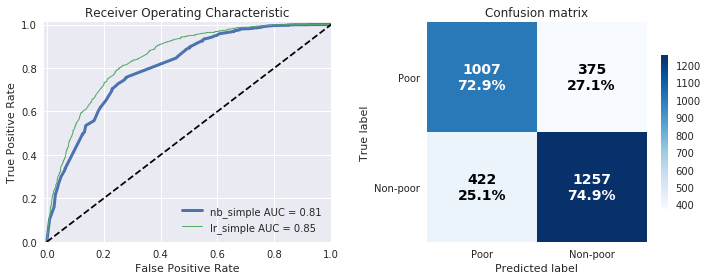

,nb_simple,lr_simple
accuracy,0.739628,0.766743
recall,0.728654,0.738784
precision,0.704689,0.743086
f1,0.716471,0.740929
cross_entropy,0.527678,0.478969
roc_auc,0.805111,0.847856
cohen_kappa,0.475883,0.528811


Actual poverty rate: 54.11% 
Predicted poverty rate: 57.56% 


In [4]:
# Naive Bayes
from sklearn.naive_bayes import BernoulliNB

# Load and transform the training data
X_train, y_train, w_train = load_data(TRAIN_PATH, 
                                      selected_columns=selected_columns)

# Fit the model
model = BernoulliNB()
%time model.fit(X_train, y_train)

# Get an initial score
%time score = model.score(X_train, y_train)
print("In-sample score: {:0.2%}".format(score))

# Load the test set
X_test, y_test, w_test = load_data(TEST_PATH, 
                                   selected_columns=selected_columns)

# Run the model
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

# Evaluate performance and store model
metrics = evaluation.evaluate_model(y_test, y_pred, y_prob, 
                                    compare_models=['lr_simple'],
                                    store_model=True,
                                    model_name='simple', 
                                    prefix=ALGORITHM_NAME,
                                    country=COUNTRY,
                                    model=model, 
                                    features=X_test.columns.values)

The basic model using default parameters performs slightly worse than our baseline logistic regression classifier. 

The Naive Bayes model gives us coefficients, but as mentioned in the introduction, the model is notoriously bad at providing probabilities, and the coefficients are not necessarily meaningful for ranking feature importance.

## BernoulliNB with all features <a class="anchor" id="all-feats"></a>

Now let's train the model with the full feature set

CPU times: user 215 ms, sys: 55.9 ms, total: 271 ms
Wall time: 275 ms
CPU times: user 212 ms, sys: 47.1 ms, total: 259 ms
Wall time: 331 ms
In-sample score: 79.82%


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


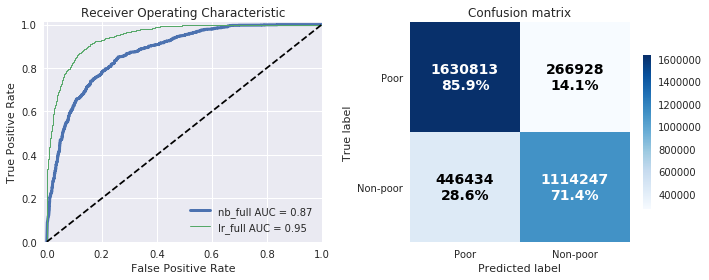

,nb_full,lr_full
accuracy,0.793732,0.873897
recall,0.859345,0.869754
precision,0.785084,0.853693
f1,0.820538,0.861649
cross_entropy,2.4725,0.288223
roc_auc,0.873451,0.948658
cohen_kappa,0.508651,0.745821


Actual poverty rate: 54.11% 
Predicted poverty rate: 59.09% 


In [5]:
# Load and transform the training data
X_train, y_train, w_train = load_data(TRAIN_PATH)

# Fit the model
model = BernoulliNB()
%time model.fit(X_train, y_train)

# Get an initial score
%time score = model.score(X_train, y_train, w_train)
print("In-sample score: {:0.2%}".format(score))

# Load the test set
X_test, y_test, w_test = load_data(TEST_PATH)

# Run the model
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

# Evaluate performance and store model
metrics = evaluation.evaluate_model(y_test, y_pred, y_prob, w_test,
                                    compare_models='lr_full',
                                    store_model=True,
                                    model_name='full', 
                                    prefix=ALGORITHM_NAME,
                                    country=COUNTRY,
                                    model=model,
                                    features=X_test.columns.values)

The full-featured model performs worse than our baseline logistic regression classifier as well.

## Tune parameters and cross-validate <a class="anchor" id="tune-cv"></a>

The BernoulliNB model has a single parameter, `alpha`, we can attempt to tune. This is an Additive smoothing parameter, with 0 meaning no smoothing, and the default being 1.0. We can try various ranges of this parameter to see which fits the data best.

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  1.7min finished


CPU times: user 36.3 s, sys: 6.67 s, total: 42.9 s
Wall time: 1min 44s
CPU times: user 238 ms, sys: 53.1 ms, total: 291 ms
Wall time: 945 ms
In-sample score: 76.09%
Best model parameters: {'alpha': 0.6951927961775619}


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


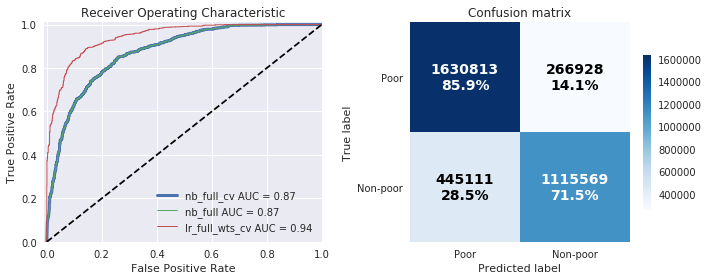

,nb_full_cv,nb_full,lr_full_wts_cv
accuracy,0.794115,0.793732,0.873458
recall,0.859345,0.859345,0.891581
precision,0.785584,0.785084,0.87947
f1,0.820811,0.820538,0.885484
cross_entropy,2.47464,2.4725,0.300498
roc_auc,0.873445,0.873451,0.944474
cohen_kappa,0.509263,0.508651,0.734446


Actual poverty rate: 54.11% 
Predicted poverty rate: 59.05% 


In [6]:
from sklearn.model_selection import GridSearchCV

# Load and transform the training data
X_train, y_train, w_train = load_data(TRAIN_PATH)


# build the model
estimator = BernoulliNB()
parameters = {'alpha': 10**np.linspace(-10,1,20)}
model = GridSearchCV(estimator, parameters, verbose=1, cv=5)
%time model.fit(X_train, y_train)
%time score = model.score(X_train, y_train)
print("In-sample score: {:0.2%}".format(score))
print("Best model parameters:", model.best_params_)

# Load the test set
X_test, y_test, w_test = load_data(TEST_PATH)

# Run the model
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

# Evaluate performance and store model
metrics = evaluation.evaluate_model(y_test, y_pred, y_prob, w_test,
                                    compare_models=['nb_full', 
                                                    'lr_full_wts_cv'],
                                    store_model=True,
                                    model_name='full_cv', 
                                    prefix=ALGORITHM_NAME,
                                    country=COUNTRY,
                                    model=model,
                                    features=X_test.columns.values)

One benefit of this model is the very low computational cost. It fits the data and provides predictions much faster than many of the other models we have explored, which could be useful if we needed to retrain a model frequently or had a high rate of incoming data to make predictions on. 

In the case of our poverty data, this is not so important. Overall, the model appears to perform worse than our baseline logistic regression model.

# Classifier Calibration - Platt Scaling <a class="anchor" id="calibration"></a>

One shortfall of Naive Bayes is that it is a poor estimator of probability, even if it serves as a good classifier. One method to improve the probability predictions is to apply calibration. Scikit-Learn provides a method for us to easily apply calibration to a classifier along with cross-validation. The two most popular calibration methods are "Platt Scaling" (also known as "Sigmoid Scaling") and "Isotonic Regression". Here, we will apply Platt scaling to the model.

**platt scaling** http://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html

**help with cccv** https://stats.stackexchange.com/questions/263393/scikit-correct-way-to-calibrate-classifiers-with-calibratedclassifiercv

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  1.7min finished


CPU times: user 39.6 s, sys: 7.32 s, total: 46.9 s
Wall time: 1min 40s
CPU times: user 244 ms, sys: 43.6 ms, total: 287 ms
Wall time: 826 ms
In-sample score: 76.09%
Best model parameters: {'alpha': 0.6951927961775619}
CPU times: user 450 ms, sys: 150 ms, total: 600 ms
Wall time: 1.8 s
CPU times: user 668 ms, sys: 109 ms, total: 777 ms
Wall time: 1.66 s
In-sample score: 76.50%


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


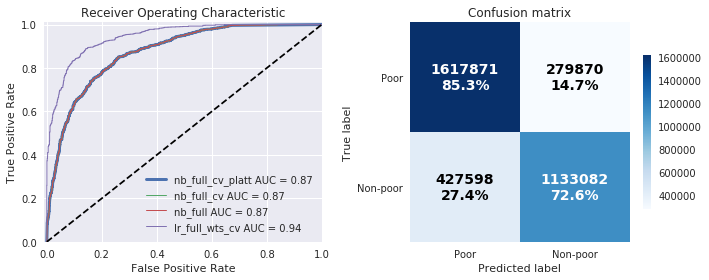

,nb_full_cv_platt,nb_full_cv,nb_full,lr_full_wts_cv
accuracy,0.795436,0.794115,0.793732,0.873458
recall,0.852525,0.859345,0.859345,0.891581
precision,0.790953,0.785584,0.785084,0.87947
f1,0.820586,0.820811,0.820538,0.885484
cross_entropy,0.519904,2.47464,2.4725,0.300498
roc_auc,0.873294,0.873445,0.873451,0.944474
cohen_kappa,0.512823,0.509263,0.508651,0.734446


Actual poverty rate: 54.11% 
Predicted poverty rate: 58.15% 


In [7]:
# platt scaling
from sklearn.calibration import CalibratedClassifierCV

# Load and transform the training data
X_train, y_train, w_train = load_data(TRAIN_PATH)

# build and fit the base model
estimator = BernoulliNB()
parameters = {'alpha': 10**np.linspace(-10,1,20)}
model = GridSearchCV(estimator, parameters, verbose=1, cv=5)
%time model.fit(X_train, y_train)
%time score = model.score(X_train, y_train)
print("In-sample score: {:0.2%}".format(score))
print("Best model parameters:", model.best_params_)

# Calibrate the model
model = CalibratedClassifierCV(model.best_estimator_, method='sigmoid')
%time model.fit(X_train, y_train)
%time score = model.score(X_train, y_train)
print("In-sample score: {:0.2%}".format(score))

# Load the test set
X_test, y_test, w_test = load_data(TEST_PATH)

# Run the model
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

# Evaluate performance and store model
metrics = evaluation.evaluate_model(y_test, y_pred, y_prob, w_test,
                                    compare_models=['nb_full_cv',
                                                    'nb_full', 
                                                    'lr_full_wts_cv'],
                                    store_model=True,
                                    model_name='full_cv_platt', 
                                    prefix=ALGORITHM_NAME,
                                    country=COUNTRY,
                                    model=model,
                                    features=X_test.columns.values)

The calibration in this case does not make a significant impact on performance, but note that the cross-entropy metric is much lower. This is the result of having more accurate probability estimates due to the calibration. 

# Naive Bayes Malawi Summary <a class="anchor" id="summary"></a>



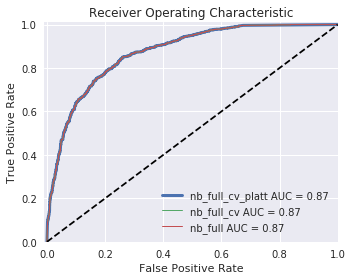

,accuracy,recall,precision,f1,cross_entropy,roc_auc,cohen_kappa,pov_rate_error
nb_full_cv_platt,0.795436,0.852525,0.790953,0.820586,0.519904,0.873294,0.512823,0.0404403
nb_full_cv,0.794115,0.859345,0.785584,0.820811,2.47464,0.873445,0.509263,0.0494285
nb_full,0.793732,0.859345,0.785084,0.820538,2.4725,0.873451,0.508651,0.0498593


In [8]:
evaluation.compare_algorithm_models(ALGORITHM_NAME, COUNTRY)